In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms, datasets
import torch.utils.data as data

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

True
1


## Load VOC2012 dataset

In [21]:
import ptsemseg
import ptsemseg.loader

In [22]:
data_loader = ptsemseg.loader.get_loader("pascal")

data_aug = None

trainset = data_loader(
        "/srv/glusterfs/yardima/datasets/voc12/VOCdevkit/VOC2012",
        is_transform=True,
        split="train_aug",
        img_size=("same", "same"),
        augmentations=data_aug)


valset = data_loader("/srv/glusterfs/yardima/datasets/voc12/VOCdevkit/VOC2012",
                        is_transform=True,
                        split="val",
                        img_size=("same", "same"),)

trainloader = data.DataLoader(trainset,
                                batch_size=1,
                                num_workers=2,
                                shuffle=True)

valloader = data.DataLoader(valset,
                            batch_size=1,
                            num_workers=2,
                            shuffle=True)

## Load trained embedding model

In [10]:
model_path_random = "/srv/glusterfs/yardima/runs/fcn8_embedding/run_5/models/embedding-fcn8-voc12-random3890852_epoch-19.pth"
model_path_min = "/srv/glusterfs/yardima/runs/fcn8_embedding_min/run_1/models/embedding-fcn8-voc12-min3890852_epoch-19.pth"
model_path_local = "/srv/glusterfs/yardima/runs/fcn8_embedding/..."

In [11]:
import deeptriplet
import deeptriplet.models
import deeptriplet.triplet

In [12]:
d1 = torch.load(model_path_random, map_location=lambda storage, loc: storage)

In [14]:
net = deeptriplet.models.FCN8Embedding(embedding_dim=30)
net = nn.DataParallel(net)
net = net.cuda()
net.load_state_dict(d1)

In [15]:
net.eval();

## The average triplet loss on validation set

In [ ]:
loss_fun = deeptriplet.triplet.RandomMinimumTriplet(n_points=700)

In [ ]:
%%time
running_loss = 0.0
count = 0
with torch.no_grad():
    for image, label in valloader: 
        image.cuda()
        out = net.forward(image)

        loss = loss_fun.compute_loss(out, label)
        running_loss += loss.item()  
        count += 1
        
        del loss, out

In [14]:
print("Average triplet loss: {}".format(running_loss / count))

Average triplet loss: 0.1790095898925325


## t-SNE samples

In [16]:
import sklearn.manifold

In [22]:
def produce_tsne(net, image, label):
    image = image.unsqueeze(0)
    label = label.unsqueeze(0)
    with torch.no_grad():
        image = image.cuda()
        out = net.forward(image)
        embeddings = out.cpu().data.numpy()
        
    embeddings = np.transpose(embeddings.squeeze(), axes=[1, 2, 0]).reshape(-1, net.module.embedding_dim)
    labels = label.reshape(-1)
    
    ix = np.random.randint(low=0, high=embeddings.shape[0], size=(500,))
    embeddings_subset = embeddings[ix, :]
    labels_subset = labels[ix]
    
    X_embedded = sklearn.manifold.TSNE(n_components=2).fit_transform(embeddings_subset)
    
    plt.figure(figsize=(12,4))

    plt.subplot(1, 3, 1)
    plt.imshow(np.transpose(image.squeeze(), axes=[1, 2, 0]))

    plt.subplot(1, 3, 2)
    plt.imshow(labels.reshape(image.shape[2], image.shape[3]))

    plt.subplot(1, 3, 3)
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels_subset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


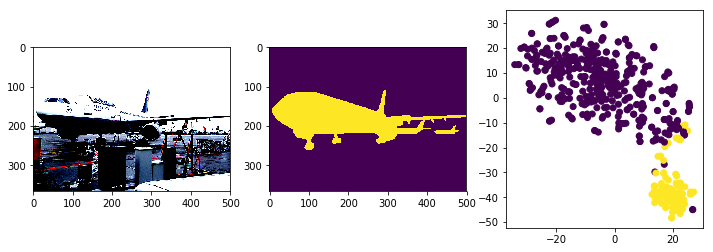

In [23]:
image, label = valset[0]
produce_tsne(net, image, label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


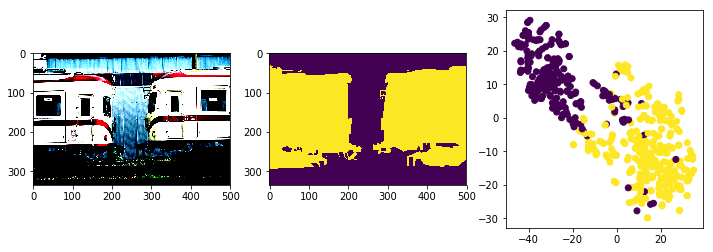

In [24]:
image, label = valset[1]
produce_tsne(net, image, label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


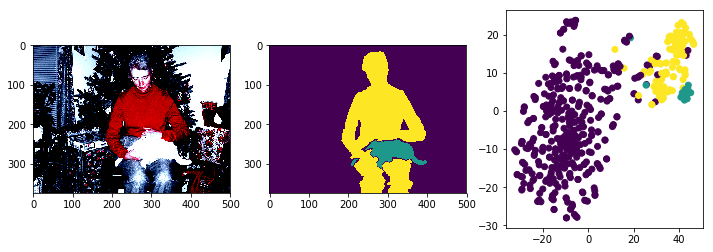

In [30]:
image, label = valset[100]
produce_tsne(net, image, label)

## Click-precision graph

In [17]:
from sklearn.neighbors import KNeighborsClassifier

In [18]:
def _fast_hist(label_true, label_pred, n_class):
        mask = (label_true >= 0) & (label_true < n_class)
        hist = np.bincount(
            n_class * label_true[mask].astype(int) + label_pred[mask],
            minlength=n_class ** 2,
        ).reshape(n_class, n_class)
        return hist

In [19]:
def get_click_precision(embeddings, labels, clicks, n_class=21):
    embeddings = embeddings.reshape(-1, embeddings.shape[-1])
    labels = labels.reshape(-1)
    
    dim = embeddings.shape[-1]
    
    i1 = np.random.randint(0, len(labels), size=(1,))[0]
    l1 = labels[i1]
    
    i2 = np.random.choice((labels != l1).nonzero()[0], size=1)[0]
    
    indices = [i1, i2]
    
    cs = []
    acc = []
    miou = []
    
    for c in range(2, clicks+1):
        
        knn = KNeighborsClassifier(n_neighbors=1)
        knn.fit(embeddings[indices,:], labels[indices])
        
        pred = knn.predict(embeddings)
        
        cs.append(c)
        
        cf_matrix = _fast_hist(labels, pred, n_class)
        
        cf_matrix = cf_matrix / np.sum(cf_matrix)
        mean_iu = np.nanmean(np.diag(cf_matrix) / (cf_matrix.sum(axis=1) + cf_matrix.sum(axis=0) - np.diag(cf_matrix)))
        
        miou.append(mean_iu)
        acc.append(np.sum(labels == pred) / len(labels))

        indices.append(np.random.choice(np.nonzero(~np.isin(labels, indices))[0], size=1)[0])
        
    return cs, acc, miou

In [147]:
image, label = valset[10]
image = image.unsqueeze(0)
label = label.unsqueeze(0)
with torch.no_grad():
    image = image.cuda()
    out = net.forward(image)
    embeddings = out.cpu().data.numpy()
    embeddings = np.transpose(embeddings.squeeze(), axes=[1, 2, 0]).reshape(-1, net.module.embedding_dim)
    label = label.data.numpy()    
c, a, iu = get_click_precision(embeddings, label, 10, n_class=21)

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid valu

In [23]:
%%time
valiter = iter(valloader)
trials = 0

n_clicks = 6
mean_acc = np.zeros(n_clicks - 1)
mean_iou = np.zeros(n_clicks - 1)

for i in range(100):
    image, label = next(valiter)
    with torch.no_grad():
        image = image.cuda()
        out = net.forward(image)
        embeddings = out.cpu().data.numpy()
        embeddings = np.transpose(embeddings.squeeze(), axes=[1, 2, 0]).reshape(-1, net.module.embedding_dim)
        label = label.data.numpy()
        
    for i in range(3):
        c, a, iu = get_click_precision(embeddings, label, n_clicks, n_class=21)
        
        mean_acc += np.array(a)
        mean_iou += np.array(iu)
        
        trials += 1
        
mean_acc /= trials
mean_iou /= trials

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid valu

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid valu

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid valu

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid valu

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid valu

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid valu

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid valu

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid valu

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid valu

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid valu

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid valu

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid valu

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid valu

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid valu

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid valu

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid valu

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid valu

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid valu

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid valu

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid valu

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid valu

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid valu

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid valu

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid valu

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid valu

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid valu

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid valu

CPU times: user 2min 36s, sys: 1min 3s, total: 3min 40s
Wall time: 6min 51s


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


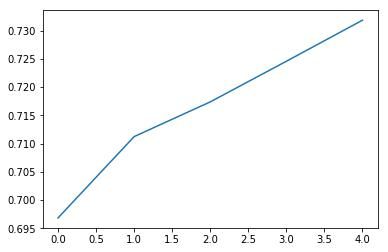

In [24]:
plt.plot(mean_iou)

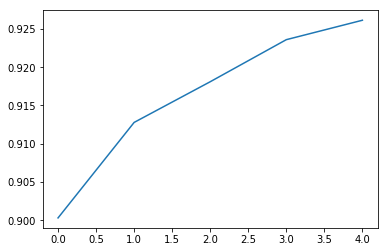

In [25]:
plt.plot(mean_acc)

In [26]:
torch.save(mean_iou, 'miou_random')
torch.save(mean_acc, 'acc_random')